# Introducción
La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Se requiere desarrollar un modelo para dicha predicción.


## Preparación

In [2]:
import pandas as pd
import pandas as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

In [4]:
# Descargamos el conjunto de datos, transformando columna datetime en datetime64 y detallando la misma como índice
try:
    taxis_df = pd.read_csv('/datasets/taxi.csv',parse_dates= [0], index_col= [0])
except:
    taxis_df = pd.read_csv('taxi.csv')

## Análisis Exploratorio

In [5]:
# Visualizamos los datos
taxis_df.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [6]:
taxis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# Ordenamos por índices en caso de que no lo esté.
taxis_df = taxis_df.sort_index()

In [6]:
# Ya que se requieere predecir la cantidad de viajes por hora vamos a realizar un remuestreo a un dia.
taxis_df = taxis_df.resample('1H').sum()
taxis_df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime'>

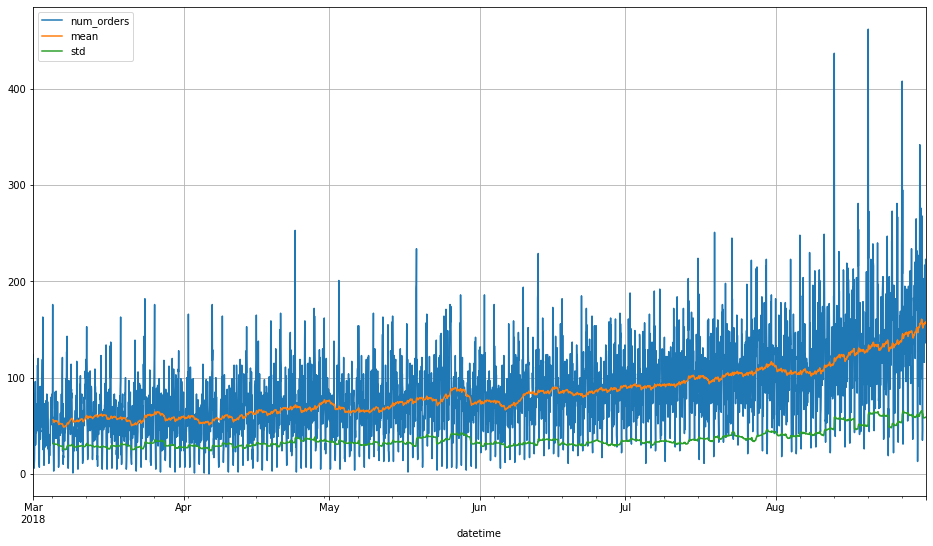

In [7]:
# Visualizamos el conjunto de datos con una media movil y desviación estandar para validaar su estacionalidad.
taxis_df_est = taxis_df.copy()
taxis_df_est['mean'] = taxis_df_est['num_orders'].rolling(100).mean()
taxis_df_est['std'] = taxis_df_est['num_orders'].rolling(100).std()

taxis_df_est.plot(figsize= (16,9), grid= True)

**Conclusiones:**

El conjunto de datos analizado en el periodo dado no es estacionaria tiene una clara tendencia al alza.

In [8]:
# Verificamos la fecha maxima y la minima.
print('Fecha máxima:', taxis_df.index.max())
print('Fecha máxima:', taxis_df.index.min())

Fecha máxima: 2018-08-31 23:00:00
Fecha máxima: 2018-03-01 00:00:00


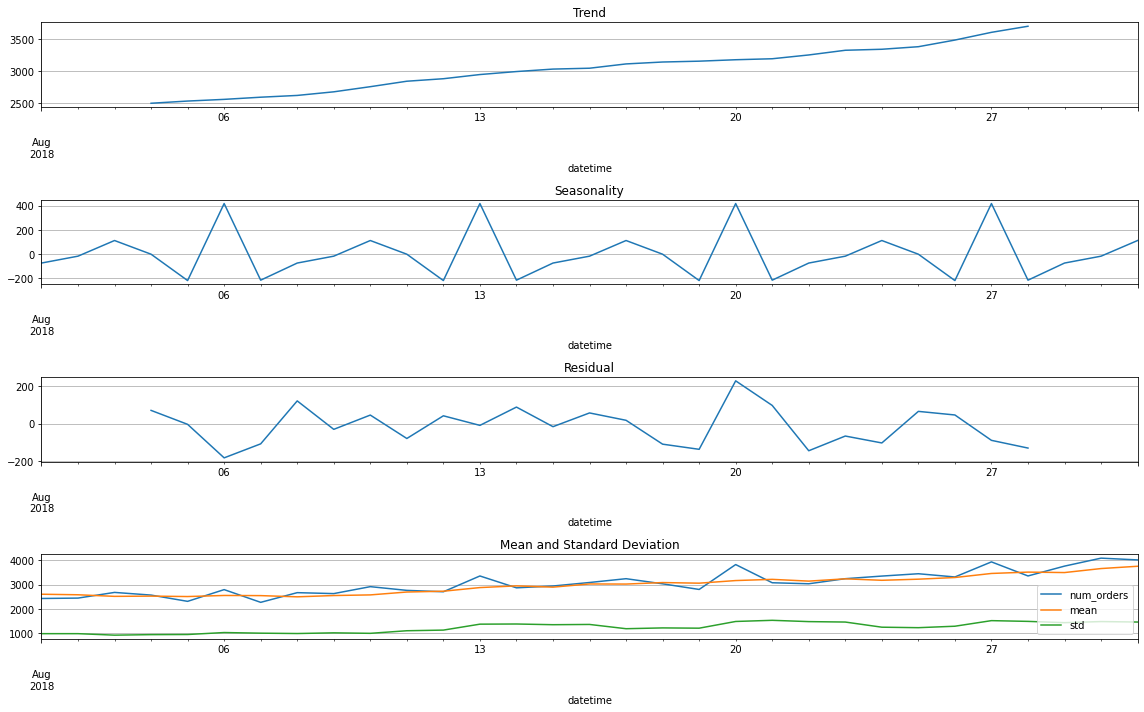

In [15]:
# Observamos la estacionalidad y tendencia del último mes en un muestreo de 1 día.

decomposed = seasonal_decompose(taxis_df['2018-08-01':'2018-08-31'].resample('1D').sum())

plt.figure(figsize=(16, 10))

plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.grid(True)

plt.subplot(412)
decomposed.seasonal.plot(ax= plt.gca())
plt.title('Seasonality')
plt.grid(True)

plt.subplot(413)
decomposed.resid.plot(ax= plt.gca())
plt.title('Residual')
plt.grid(True)

plt.subplot(414)
taxis_df_est['2018-08-01':'2018-08-31'].resample('1D').sum().plot(ax= plt.gca())
plt.title('Mean and Standard Deviation')
plt.grid(True)

plt.tight_layout()

**Conclusiones:**

- Podemos concluir que hay una tendencia alcista en cuanto a número de viajes diarios en el último mes.

- También podemos observar que los días lunes el número de pedidos aumenta, támbién tenemos un pico de pedidos los días viernes.

- Con respecto al análisis del periodo podemos observar que la media y la desviación estandard aumentan en cada periodo, por lo tanto no es estacionaria.

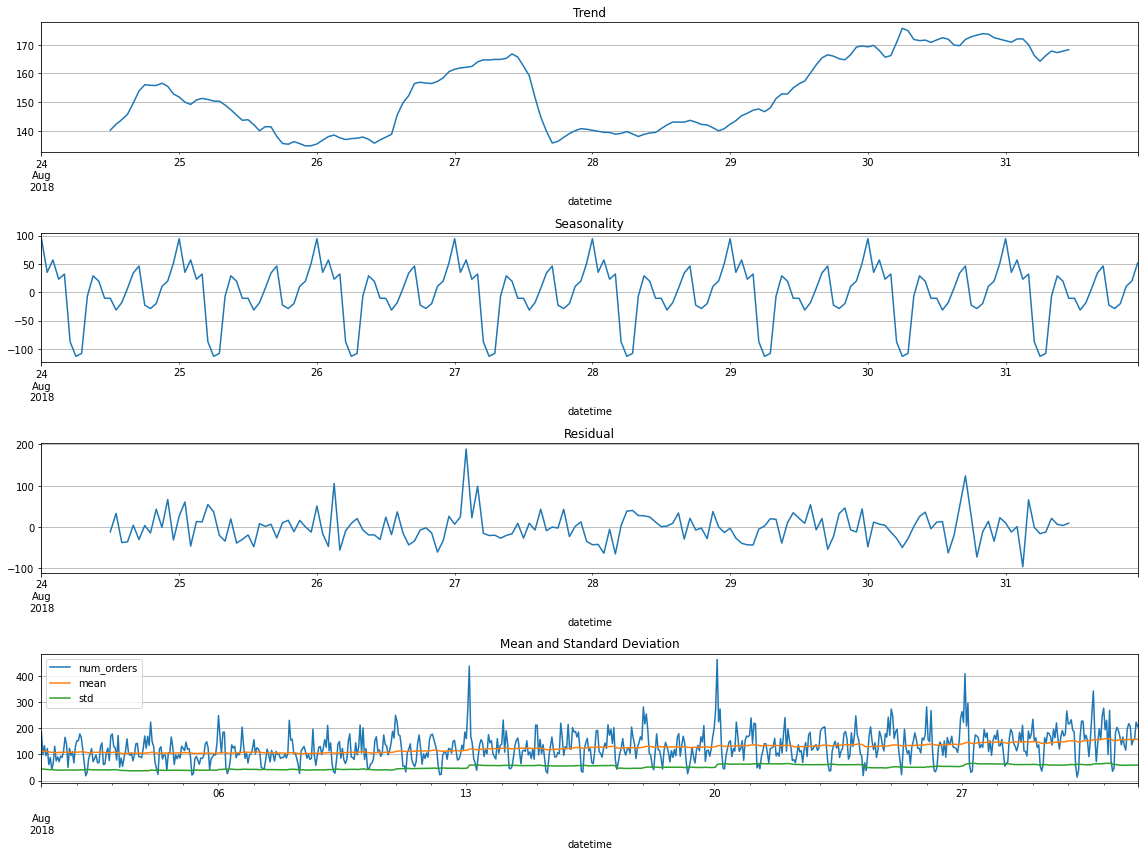

In [16]:
# Observamos la estacionalidad y tendencia del último mes en un muestreo de 1 día.

decomposed = seasonal_decompose(taxis_df['2018-08-24':'2018-08-31'])

plt.figure(figsize=(16, 12))

plt.subplot(411)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.grid(True)

plt.subplot(412)
decomposed.seasonal.plot(ax= plt.gca())
plt.title('Seasonality')
plt.grid(True)

plt.subplot(413)
decomposed.resid.plot(ax= plt.gca())
plt.title('Residual')
plt.grid(True)

plt.subplot(414)
taxis_df_est['2018-08-01':'2018-08-31'].plot(ax= plt.gca())
plt.title('Mean and Standard Deviation')
plt.grid(True)

plt.tight_layout()

**Conclusiones:**

- Analizando la última semana también podemos observar que la tendencia alcista se mantiene.

- En cuanto a la estacionalidad podemos observar que hay un pico de pedidos a laa 0h00 y tenemos un valle a las 6h00.

- Tomando en cuenta la desviación standard y la media mobil, se puede observar que varía levemente con una tendencia alcista, esto confirma que no es estacionaria.

## Formación

In [11]:
# Definimos una función para agregar características a nuestro conjunto de datos

def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = (data['num_orders'].shift().rolling(rolling_mean_size).mean())
    
    return data

### Regresión lineal

In [12]:
#Entrenamos un  modelo de regresión lineal.
for lag in range(1,10):
    for mean in range(1,10):
        data_reg = make_features(taxis_df, lag, mean)
        
        train, test = train_test_split(data_reg, test_size= 0.1, shuffle= False) 
        
        train = train.dropna()
        
        X_train = train.drop('num_orders', axis= 1)
        X_test = test.drop('num_orders', axis= 1)
        y_train = train['num_orders']
        y_test = test['num_orders']

        model_reg = LinearRegression()
        model_reg.fit(X_train, y_train)
        predictions_reg = model_reg.predict(X_test)
        
        print('lag: ', lag)
        print('mean: ', mean)
        print('RECM: ', mean_squared_error(predictions_reg, y_test)**0.5)
        print()


lag:  1
mean:  1
RECM:  52.85523155331338

lag:  1
mean:  2
RECM:  52.7694705806925

lag:  1
mean:  3
RECM:  52.85845367266398

lag:  1
mean:  4
RECM:  52.90586105514353

lag:  1
mean:  5
RECM:  53.02745879232517

lag:  1
mean:  6
RECM:  53.324125379325366

lag:  1
mean:  7
RECM:  53.41105708807823

lag:  1
mean:  8
RECM:  53.461846242436906

lag:  1
mean:  9
RECM:  53.79903343211882

lag:  2
mean:  1
RECM:  52.7694705806925

lag:  2
mean:  2
RECM:  52.769470580692484

lag:  2
mean:  3
RECM:  52.454209415117894

lag:  2
mean:  4
RECM:  52.60465033162614

lag:  2
mean:  5
RECM:  52.8781603286867

lag:  2
mean:  6
RECM:  53.33189258317084

lag:  2
mean:  7
RECM:  53.475774128449935

lag:  2
mean:  8
RECM:  53.52294296320366

lag:  2
mean:  9
RECM:  53.886448736836

lag:  3
mean:  1
RECM:  52.470713114886145

lag:  3
mean:  2
RECM:  52.45420941511783

lag:  3
mean:  3
RECM:  52.454209415117845

lag:  3
mean:  4
RECM:  52.62032129288975

lag:  3
mean:  5
RECM:  52.799813248460936

lag:  3


In [13]:
data = make_features(taxis_df, 6, 11)
train, test = train_test_split(data, test_size= 0.1, shuffle= False) 
train = train.dropna()
X_train = train.drop('num_orders', axis= 1)
X_test = test.drop('num_orders', axis= 1)
y_train = train['num_orders']
y_test = test['num_orders']

### Random Forest Regressor

In [14]:
random_model = RandomForestRegressor()

params = {
    'max_depth':range(1,10),
    'n_estimators':range(100,200,10),
    'random_state':[42]
}

grid = GridSearchCV(estimator= random_model, param_grid= params, scoring= 'neg_root_mean_squared_error', cv= 3)
grid.fit(X_train, y_train)

predictions_ran = grid.predict(X_test)

print('RECM de Random Tree Regressor: ', mean_squared_error(predictions_ran, y_test)**0.5)
print('Best params: ', grid.best_params_)

RECM de Random Tree Regressor:  55.11584401954767
Best params:  {'max_depth': 9, 'n_estimators': 190, 'random_state': 42}


### CatBoost

In [16]:

best_rsme = 10000
best_iterations = None
best_learning_rate = None
best_depth = None

for iteration in range(100,200,10):
    for learning_r in [0.1,0.5,1]:
        for depth in range(1,16):
            cat_model = CatBoostRegressor(random_seed=42, silent=True, iterations= iteration, learning_rate= learning_r,
                                          depth= depth)
            cat_model.fit(X_train, y_train)
            predictions_cat = cat_model.predict(X_test)
            rsme = mean_squared_error(predictions_cat, y_test)**0.5
            if rsme < best_rsme:
                best_rsme = rsme
                best_iterations = iteration
                best_learning_rate = learning_r
                best_depth = depth
                
print('RECM: ', best_rsme)
print('Best_iterations: ', best_iterations)
print('Best_learing_rate: ', best_learning_rate)
print('Best_depth: ', best_depth)

RECM:  51.633218906126956
Best_iterations:  180
Best_learing_rate:  0.1
Best_depth:  6


## Prueba

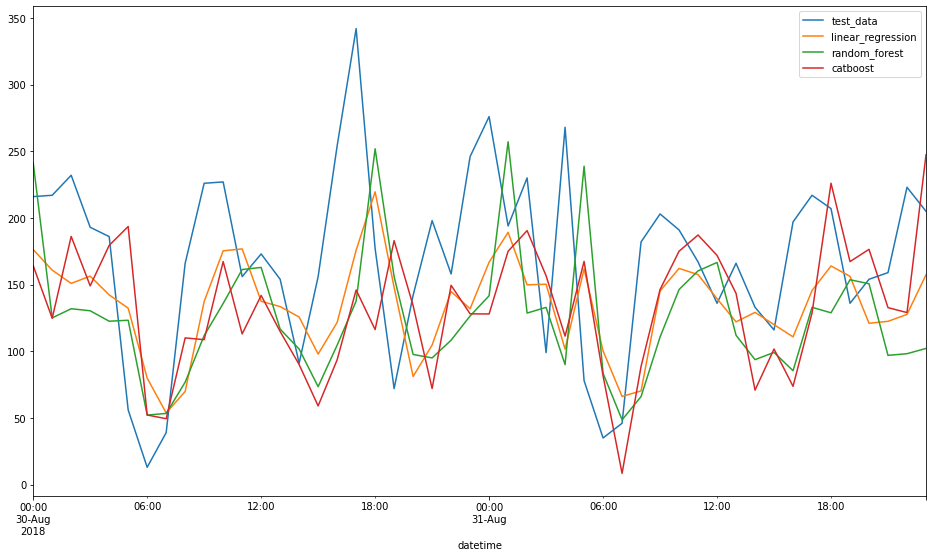

In [37]:
# Visualizamos las predicciones de los diferentes modelos vs los valores reales y analizaremos caul predice mejor.
data = {}
data['test_data'] = list(y_test)
data['linear_regression'] = list(predictions_reg)
data['random_forest'] = list(predictions_ran)
data['catboost'] = list(predictions_cat)

data_df = pd.DataFrame(data, index= y_test.index)
data_df['2018-08-30':'2018-08-31'].plot(figsize= (16, 9))
plt.show()

**Conclusiones:**

Luego de evaluar los diferentes modelos evidentemente el modelo con mejor resultado es el catboost ya que tiene un RECM de 51.63, mientras que los modelos de Random Forest Regressor y Regresion Lineal teinen 55.11 y 52.76 respectivamente. Realizamos un gráfico para visualizar que tan bien se adaptan las prediciones de diferentes modelos a los patrones de cambio para evaluar no solo la diferencia de valores, y llgamos a la conclusión de que el modelo de catboost se adapta de mejor manera a los patrones de picos y valles.